<a href="https://colab.research.google.com/github/chandradutta/DL_Assignment_2/blob/main/Part_A/Assignmnet2_Part_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#installing wandb
!pip install wandb
import wandb
from wandb.keras import WandbCallback
import socket
socket.setdefaulttimeout(30)
wandb.login()
wandb.init(project='DL_Assignment_2')

^C
ERROR: Operation cancelled by user


2024-04-12 15:55:41.120263: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 15:55:41.120364: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 15:55:41.229241: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Exception ignored in: <function _xla_gc_callback at 0x7faa2d455090>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 97, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
w

Abort: 

In [ ]:

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset,Subset
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchvision.datasets import ImageFolder
import torch.nn.functional as func
# import wandb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import DataLoader
import torchvision



In [ ]:
!wget https://storage.googleapis.com/wandb_datasets/nature_12K.zip -O nature_12K.zip
!unzip -q nature_12K.zip
!rm nature_12K.zip

--2024-04-12 18:15:47--  https://storage.googleapis.com/wandb_datasets/nature_12K.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.207, 173.194.202.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3816687935 (3.6G) [application/zip]
Saving to: 'nature_12K.zip'

nature_12K.zip      100%[===================>]   3.55G  94.2MB/s    in 39s     

2024-04-12 18:16:27 (93.0 MB/s) - 'nature_12K.zip' saved [3816687935/3816687935]



In [ ]:
from tqdm import tqdm

In [ ]:
dataset = torchvision.datasets.ImageFolder(root='inaturalist_12K/train', transform=transforms)
from torchvision import transforms
transform = transforms.Compose([transforms.Resize((200,200)),transforms.ToTensor(),transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229, 0.224, 0.225])])

train_dataset = ImageFolder(root='inaturalist_12K/train', transform=transform)
test_dataset = ImageFolder(root='inaturalist_12K/val', transform=transform)
# test_dataset = ImageFolder(root='inaturalist_12K/val', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the size of the validation set (20%)
validation_size = 0.2

# Split the dataset into training and validation sets with shuffling
train_data, val_data = train_test_split(list(range(len(train_dataset))), test_size=validation_size, shuffle=True, random_state=42)
#Data Loader

train_subset = Subset(train_dataset, train_data)
val_subset  = Subset(train_dataset, val_data)

# train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_subset, batch_size=32, shuffle=True)

# train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
# val_loader = DataLoader(val_data, batch_size=32, shuffle=True)
# print(len(train_dataset))
# print(len(test_dataset))
# print(len(train_data))
# print(len(val_data))

# dataiter = iter(train_loader)
# data = next(dataiter)
# inputs, targets = data
# print(inputs.shape, targets.shape)

In [ ]:
def DataLoaders(aug,batch_size):
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=True)
    return train_loader,val_loader

In [ ]:
import math
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def choose_optimizer(algo,epochs,eta,n_filters,filter_size,activationFun,denseLay,aug,batch_size,drop_out,norm):
    if algo == 'adam':
        Network=ConvNetwork(n_filters,filter_size,activationFun,denseLay,drop_out,norm).to(device)
        Algo = torch.optim.Adam(Network.parameters(), lr=eta)
        train_model(epochs,Network,Algo,activationFun,aug,batch_size)
    if algo == 'nadam':
        Network=ConvNetwork(n_filters,filter_size,activationFun,denseLay,drop_out,norm).to(device)
        Algo = torch.optim.NAdam(Network.parameters(), lr=eta)
        train_model(epochs,Network,Algo,activationFun,aug,batch_size)
    if algo == 'sgd':
        Network=ConvNetwork(n_filters,filter_size,activationFun,denseLay,drop_out,norm).to(device)
        Algo = torch.optim.SGD(Network.parameters(), lr=eta)
        train_model(epochs,Network,Algo,activationFun,aug,batch_size)


def compute_size(input_size, kernel_size,stride):
    padding=0
    output_size = math.floor((input_size - kernel_size + 2 * padding) / stride) + 1
#     print(output_size)
    return output_size

class ConvNetwork(nn.Module):
    def __init__(self,n_filters,filter_size,activationFun,denseLay,drop_out,norm):
        super(ConvNetwork, self).__init__()
        self.drop_out = drop_out
        self.norm = norm
        self.conv1 = nn.Conv2d(3,n_filters,filter_size,stride=1)
        self.norm1 = nn.BatchNorm2d(n_filters)
        self.size_after_conv1 = compute_size(200, filter_size, stride=1)
        self.pool1 = nn.MaxPool2d(filter_size,stride=2)
        self.size_after_pool1 = compute_size(self.size_after_conv1, filter_size, stride=2)

        self.conv2 = nn.Conv2d(n_filters, n_filters*2,filter_size,stride=1)
        self.norm2 = nn.BatchNorm2d(n_filters*2)
        self.size_after_conv2 = compute_size(self.size_after_pool1, filter_size, stride=1)
        self.pool2 = nn.MaxPool2d(filter_size,stride=2)
        self.size_after_pool2 = compute_size(self.size_after_conv2, filter_size, stride=2)

        self.conv3 = nn.Conv2d(n_filters*2,n_filters*4,filter_size,stride=1)
        self.norm3 = nn.BatchNorm2d(n_filters*4)
        self.size_after_conv3 = compute_size(self.size_after_pool2, filter_size, stride=1)
        self.pool3= nn.MaxPool2d(filter_size,stride=2)
        self.size_after_pool3 = compute_size(self.size_after_conv3, filter_size, stride=2)

        self.conv4 = nn.Conv2d(n_filters*4,n_filters*8,filter_size,stride=1)
        self.norm4 = nn.BatchNorm2d(n_filters*8)
        self.size_after_conv4 = compute_size(self.size_after_pool3, filter_size, stride=1)
        self.pool4 = nn.MaxPool2d(filter_size,stride=2)
        self.size_after_pool4 = compute_size(self.size_after_conv4, filter_size, stride=2)


        self.conv5 = nn.Conv2d(n_filters*8,n_filters*16,filter_size,stride=1)
        self.norm5 = nn.BatchNorm2d(n_filters*16)
        self.size_after_conv5 = compute_size(self.size_after_pool4, filter_size, stride=1)
        self.pool5 = nn.MaxPool2d(filter_size,stride=2)
        self.size_after_pool5 = compute_size(self.size_after_conv5, filter_size, stride=2)

        self.drop_out = nn.Dropout(p=drop_out)

        # Fully connected layers
        self.fc1 = nn.Linear(n_filters*16 * (self.size_after_pool5)*(self.size_after_pool5), denseLay)
        self.normFC1 = nn.BatchNorm1d(denseLay)
        self.opLay = nn.Linear(denseLay, 10)

    def _get_activation_function(self, activation):
        # Return the appropriate activation function based on the input argument
        if activation == 'relu':
            return func.relu
        elif activation == 'gelu':
            return func.gelu
        elif activation == 'silu':
            return func.silu
        else:
            return func.mish


    def forward(self, img,activationFun):
        # Define activation function based on the input argument
        activation_fn = self._get_activation_function(activationFun)

        # Apply convolutional layers followed by activation and pooling
        if(self.norm == 'true'):
            img = self.pool1(activation_fn(self.norm1(self.conv1(img))))
        else:
            img = self.pool1(activation_fn(self.conv1(img)))
        if(self.norm == 'true'):
            img = self.pool2(activation_fn(self.norm2(self.conv2(img))))
        else:
            img = self.pool2(activation_fn(self.conv2(img)))
        if(self.norm == 'true'):
            img = self.pool3(activation_fn(self.norm3(self.conv3(img))))
        else:
            img = self.pool3(activation_fn(self.conv3(img)))
        if(self.norm=='true'):
            img = self.pool4(activation_fn(self.norm4(self.conv4(img))))
        else:
            img = self.pool4(activation_fn(self.conv4(img)))
        if(self.norm == 'true'):
            img = self.pool5(activation_fn(self.norm5(self.conv5(img))))
        else:
            img = self.pool5(activation_fn(self.conv5(img)))

        #reshaping
        img=img.reshape(img.shape[0],-1)
        if(self.norm == 'true'):
            img = activation_fn(self.normFC1(self.fc1(img)))
        else:
            img = activation_fn(self.fc1(img))
        img = self.drop_out(img)
        img = self.opLay(img)
        return img

# learning_rate=0.0001
# epochs=10
# n_filters = 128
# filter_size = 3
# denseLay = 64
# activationFun='relu'



LossFun = nn.CrossEntropyLoss()

def train_model(epochs,Network,Algo,activationFun,aug,batch_size):
    train_loader,val_loader = DataLoaders(aug,batch_size)
    for epoch in range(epochs):
        for i,(images,labels) in enumerate(tqdm(train_loader)):

            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = Network(images,activationFun)
            loss = LossFun(outputs, labels)

            # Backward and optimize
            Network.zero_grad()
            loss.backward()
            Algo.step()
        test_acc,test_loss=calculate_accuracy(Network,test_loader,activationFun)
#         train_acc,train_loss = calculate_accuracy(Network,train_loader,activationFun)
#         Validation_acc,val_loss=calculate_accuracy(Network, val_loader,activationFun)

#         wandb.log({"Validation_acc" : Validation_acc})
#         wandb.log({"val_loss" : val_loss})
#         wandb.log({"train_acc" : train_acc})
#         wandb.log({"train_loss" : train_loss})
        print(test_acc,test_loss)
#         print(train_acc,train_loss)
#         print(Validation_acc,val_loss)


#accuracy
def calculate_accuracy(model, data_loader,activationFun):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    num_loss=0
    total_length = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images=images.to(device=device)
            labels=labels.to(device=device)
            outputs = model(images,activationFun)
            loss=LossFun(outputs,labels)
            num_loss+=loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            total_length += predicted.size(0)
    accuracy = correct / total
    loss=num_loss/total_length
    model.train()
    return accuracy,loss


# choose_optimizer('adam',10,0.0001,128,3,'relu',64)

In [ ]:
algo='adam'
epochs=5
eta=1e-4
n_filters=32
filter_size=3
activationFun='relu'
denseLay=256
aug='no'
batch_size=32
drop_out=0.4
norm = 'true'
choose_optimizer(algo,epochs,eta,n_filters,filter_size,activationFun,denseLay,aug,batch_size,drop_out,norm)

100%|██████████| 250/250 [01:25<00:00,  2.91it/s]


0.344 0.059300357460975645


100%|██████████| 250/250 [01:25<00:00,  2.94it/s]


0.3605 0.057821353673934935


100%|██████████| 250/250 [01:24<00:00,  2.94it/s]


0.39 0.055822205722332


100%|██████████| 250/250 [01:25<00:00,  2.93it/s]


0.405 0.05531768977642059


100%|██████████| 250/250 [01:24<00:00,  2.95it/s]


0.403 0.05414205312728882


In [ ]:
# config = wandb.config
#     run_name = f"{config.optimization_algorithm}_{config.activationfun}_{config.n_filters}_{config.filter_size}_{config.denseLay}"
#     # Set the run name
#     wandb.run.name = run_name
#     wandb.run.save()



def mainfunction(algo,epochs,eta,n_filters,filter_size,activationFun,denseLay,aug,batch_size,drop_out,norm):
    if algo == 'adam':
        choose_optimizer(algo,epochs,eta,n_filters,filter_size,activationFun,denseLay,aug,batch_size,drop_out,norm)
    if algo == 'nadam':
        choose_optimizer(algo,epochs,eta,n_filters,filter_size,activationFun,denseLay,aug,batch_size,drop_out,norm)
    if algo == 'sgd':
        choose_optimizer(algo,epochs,eta,n_filters,filter_size,activationFun,denseLay,aug,batch_size,drop_out,norm)
def main():
    wandb.init(project="DL_Assignment_2", entity="cs23m021")
    config = wandb.config
    run_name = f"{config.optimization_algorithm}_{config.activationfun}_{config.n_filters}_{config.filter_size}_{config.denseLay}"
    # Set the run name
    wandb.run.name = run_name
    wandb.run.save()

    p=wandb.config
    with wandb.init(project='DL_Assignment_2') as run:
        mainfunction(p.optimization_algorithm,p.max_epochs,p.learning_rate,p.n_filters,p.filter_size,p.activationfun,p.denseLay,p.aug,p.batch_size,p.drop_out,p.norm)

parameters_from_sweep = {
    'method' : 'bayes',
    'name'   : 'Accuracy',
    'metric' : {
        'goal' : 'maximize',
        'name' : 'Validation_acc',
    },
    'parameters' : {
        'n_filters':{'values':[32,64,128]},
        'optimization_algorithm':{'values':['adam','nadam','sgd']},
        'max_epochs' : {'values' : [5,10]},
        'filter_size'       : {'values' : [3]},
        'learning_rate' : {'values' : [0.001,0.0001]},
        'denseLay' : {'values': [64,128,256]},
        'activationfun' : {'values' : ['relu','gelu','silu','mish']},
        'aug': {'values':['yes','no']},
        'batch_size':{'values':[32,64]},
        'drop_out':{'values':[0,0.2,0.4]},
        'norm':{'values':['true','false']}
    }
}

sweepId = wandb.sweep(parameters_from_sweep,project = 'DL_Assignment_2')

wandb.agent(sweepId,function=main,count=10)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

In [ ]:
def train_model(epochs,Network,Algo,activationFun,aug,batch_size):
    train_loader,val_loader = DataLoaders(aug,batch_size)
    LossFun = nn.CrossEntropyLoss()
    for epoch in range(epochs):
        for i,(images,labels) in enumerate(tqdm(train_loader)):

            images = images.to(device)
            labels = labels.to(device)
            # Forward pass
            outputs = Network(images,activationFun)
            loss = LossFun(outputs, labels)

            # Backward and optimize
            Network.zero_grad()
            loss.backward()
            Algo.step()
#         train_acc,train_loss = calculate_accuracy(Network,train_loader,activationFun)
#         Validation_acc,val_loss=calculate_accuracy(Network, val_loader,activationFun)
#         wandb.log({"Validation_acc" : Validation_acc})
#         wandb.log({"val_loss" : val_loss})
#         wandb.log({"train_acc" : train_acc})
#         wandb.log({"train_loss" : train_loss})
#         print(train_acc,train_loss)
#         print(Validation_acc,val_loss)
    return Network

100%|██████████| 250/250 [01:35<00:00,  2.61it/s]


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


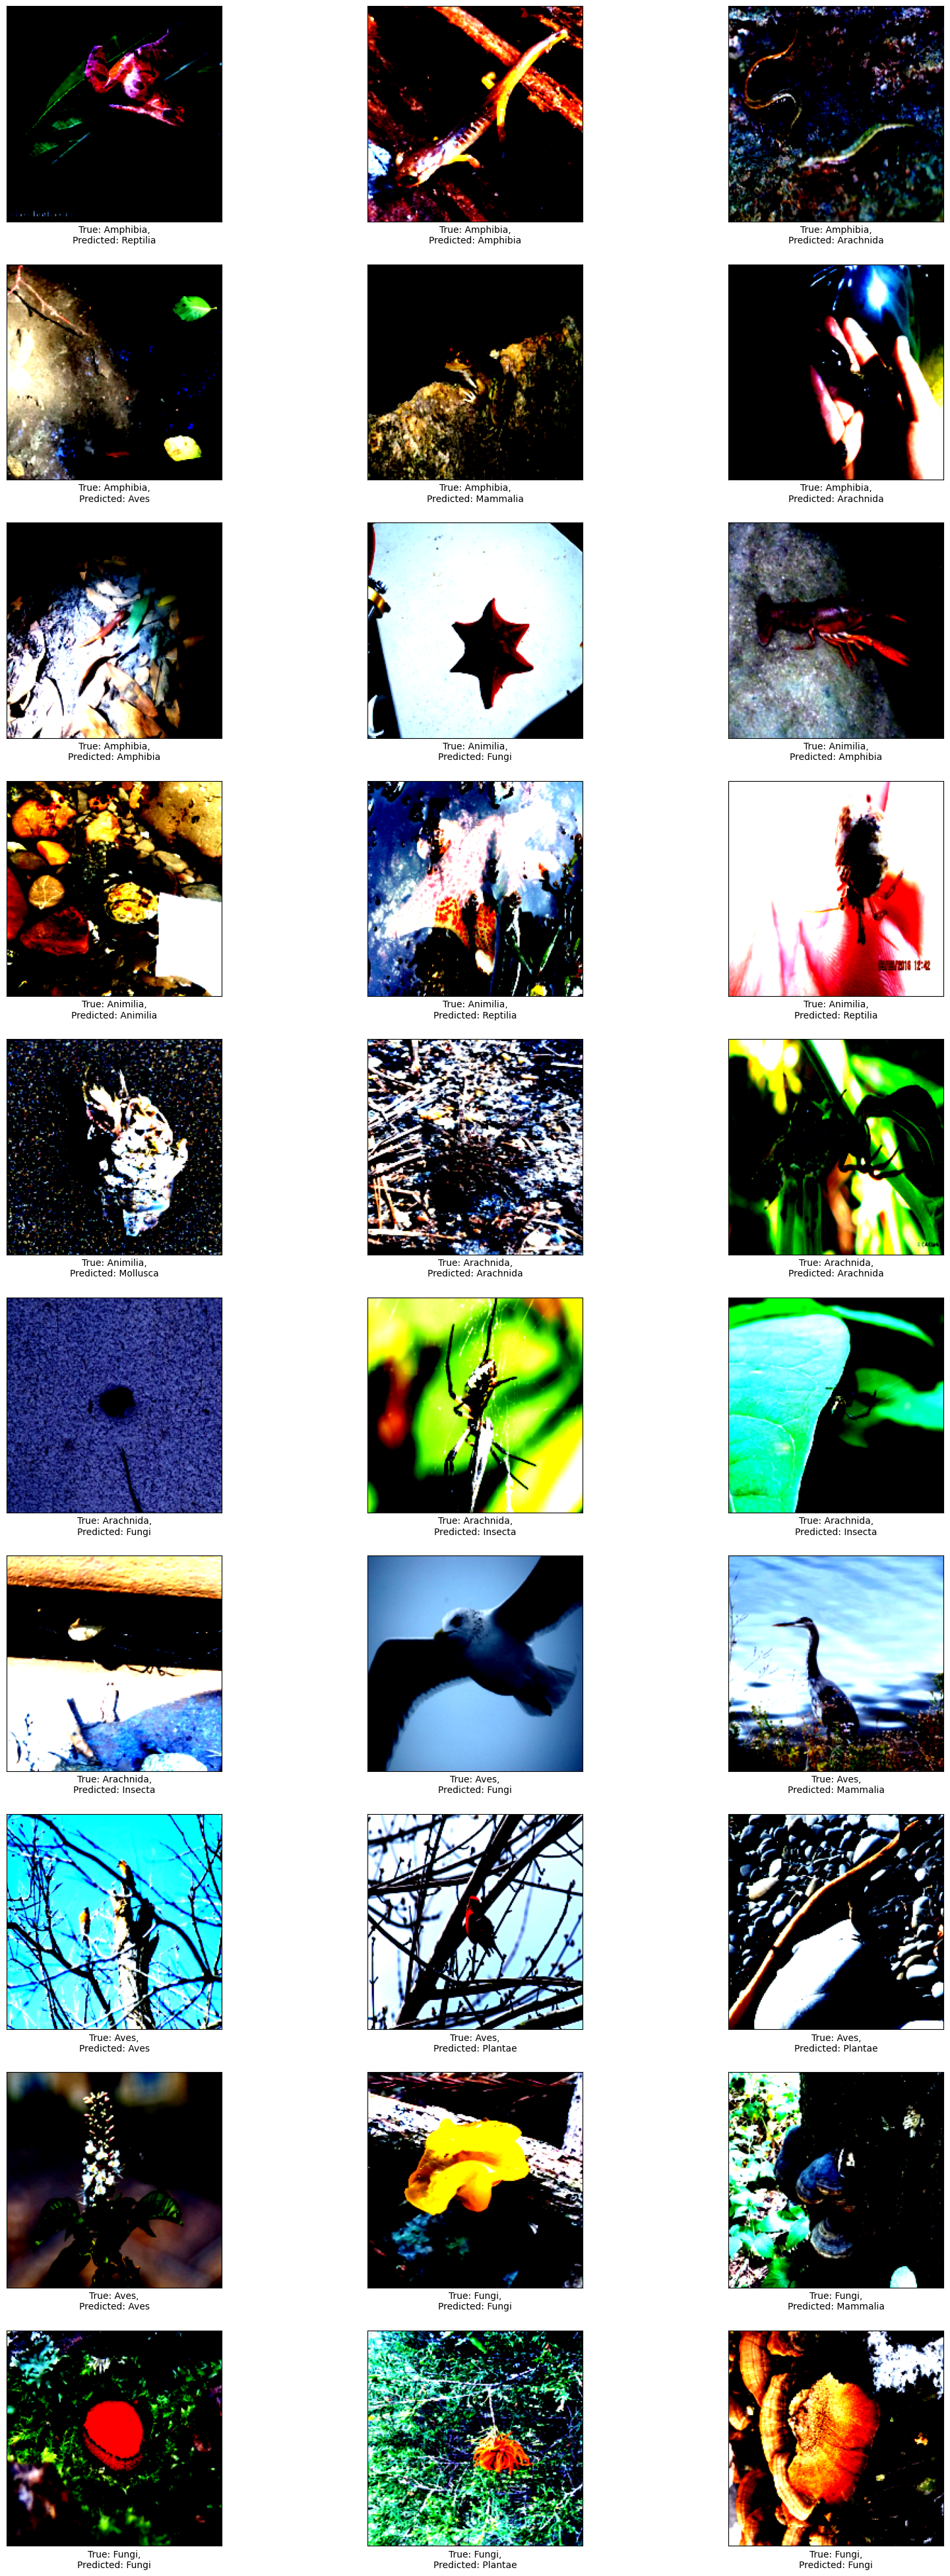

In [ ]:
# algo='nadam'
# epochs=10
# eta=1e-4
# n_filters=128
# filter_size=3
# activationFun='relu'
# denseLay=256
# aug='yes'
# batch_size=32
# drop_out=0.4
# norm = 'false'
# choose_optimizer(algo,epochs,eta,n_filters,filter_size,activationFun,denseLay,aug,batch_size,drop_out,norm)

In [ ]:
import math
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def choose_optimizer(algo,epochs,et,n_filters,filter_size,activationFun,denseLay,aug,batch_size,drop_out,norm):
    if algo == 'adam':
        Network=ConvNetwork(n_filters,filter_size,activationFun,denseLay,drop_out,norm).to(device)
        Algo = torch.optim.Adam(Network.parameters(), lr=eta)
        model=train_model(epochs,Network,Algo,activationFun,aug,batch_size)
    if algo == 'nadam':
        Network=ConvNetwork(n_filters,filter_size,activationFun,denseLay,drop_out,norm).to(device)
        Algo = torch.optim.NAdam(Network.parameters(), lr=eta)
        model=train_model(epochs,Network,Algo,activationFun,aug,batch_size)
    if algo == 'sgd':
        Network=ConvNetwork(n_filters,filter_size,activationFun,denseLay,drop_out,norm).to(device)
        Algo = torch.optim.SGD(Network.parameters(), lr=eta)
        model=train_model(epochs,Network,Algo,activationFun,aug,batch_size)
    calculate_accuracy(model,test_loader,activationFun)

In [ ]:
transform = transforms.Compose([transforms.Resize((200,200)),transforms.ToTensor(),transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229, 0.224, 0.225])])
test_dataset = ImageFolder(root='inaturalist_12K/val', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
def calculate_accuracy(model, test_loader,activationFun):
#     model.eval()  # Set the model to evaluation mode
#     correct = 0
#     total = 0
#     num_loss=0
#     total_length = 0
#     labels=['Amphibia','Animilia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
#     count=0
#     i=1
#     fig,axes=plt.subplots(10,3,figsize=(20,50))
#     with torch.no_grad():
#         for images, labels in data_loader:
#             images=images.to(device=device)
#             labels=labels.to(device=device)
#             outputs = model(images,activationFun)
#             loss=LossFun(outputs,labels)
#             num_loss+=loss.item()
#             _, predicted = torch.max(outputs, 1)
#             total += labels.size(0)
#             correct += (predicted == labels).sum().item()
#             total_length += predicted.size(0)
#     accuracy = correct / total
#     loss=num_loss/total_length
#     model.train()
#     return accuracy,loss
    model.eval()  # Set the model to evaluation mode
    num_correct = 0
    total = 0
    num_loss=0
    total_length = 0
    labels=['Amphibia','Animilia','Arachnida','Aves','Fungi','Insecta','Mammalia','Mollusca','Plantae','Reptilia']
    count=0
    i=1
    fig, axes = plt.subplots(10, 3, figsize=(20, 50))
    criterion=nn.CrossEntropyLoss()
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device=device)
            y = y.to(device=device)

            scores = model(x,activationFun)
            loss = criterion(scores, y)

            num_loss += loss.item()
            _, predictions = scores.max(1)

#                 if i % 2 == 0:
            if count < 30:
                print(i)
                i+=1

                ax = axes[count // 3, count % 3]
                ax.imshow(x[3].cpu().numpy().transpose(1, 2, 0))
                ax.set_xticks([])
                ax.set_yticks([])
                ax.set_xlabel(f'True: {labels[y[0].item()]},\nPredicted: {labels[predictions[0].item()]}')
                count += 1

#             i += 1
            total += y.size(0)
#             num_correct += predictions.eq(y).sum().item()

#         val_accuracy = 100 * num_correct / total
#         val_loss = num_loss / len(test_loader)
#         print(f"Test_acc : {val_accuracy}, Test_loss : {val_loss}, epoch:{i}")

    # Save the figure
    plt.savefig('all_images.png')
    plt.show()

In [ ]:
def compute_size(input_size, kernel_size,stride):
    padding=0
    output_size = math.floor((input_size - kernel_size + 2 * padding) / stride) + 1
#     print(output_size)
    return output_size
class ConvNetwork(nn.Module):
    def __init__(self,n_filters,filter_size,activationFun,denseLay,drop_out,norm):
        super(ConvNetwork, self).__init__()
        self.drop_out = drop_out
        self.norm = norm
        self.conv1 = nn.Conv2d(3,n_filters,filter_size,stride=1)
        self.norm1 = nn.BatchNorm2d(n_filters)
        self.size_after_conv1 = compute_size(200, filter_size, stride=1)
        self.pool1 = nn.MaxPool2d(filter_size,stride=2)
        self.size_after_pool1 = compute_size(self.size_after_conv1, filter_size, stride=2)

        self.conv2 = nn.Conv2d(n_filters, n_filters*2,filter_size,stride=1)
        self.norm2 = nn.BatchNorm2d(n_filters*2)
        self.size_after_conv2 = compute_size(self.size_after_pool1, filter_size, stride=1)
        self.pool2 = nn.MaxPool2d(filter_size,stride=2)
        self.size_after_pool2 = compute_size(self.size_after_conv2, filter_size, stride=2)

        self.conv3 = nn.Conv2d(n_filters*2,n_filters*4,filter_size,stride=1)
        self.norm3 = nn.BatchNorm2d(n_filters*4)
        self.size_after_conv3 = compute_size(self.size_after_pool2, filter_size, stride=1)
        self.pool3= nn.MaxPool2d(filter_size,stride=2)
        self.size_after_pool3 = compute_size(self.size_after_conv3, filter_size, stride=2)

        self.conv4 = nn.Conv2d(n_filters*4,n_filters*8,filter_size,stride=1)
        self.norm4 = nn.BatchNorm2d(n_filters*8)
        self.size_after_conv4 = compute_size(self.size_after_pool3, filter_size, stride=1)
        self.pool4 = nn.MaxPool2d(filter_size,stride=2)
        self.size_after_pool4 = compute_size(self.size_after_conv4, filter_size, stride=2)


        self.conv5 = nn.Conv2d(n_filters*8,n_filters*16,filter_size,stride=1)
        self.norm5 = nn.BatchNorm2d(n_filters*16)
        self.size_after_conv5 = compute_size(self.size_after_pool4, filter_size, stride=1)
        self.pool5 = nn.MaxPool2d(filter_size,stride=2)
        self.size_after_pool5 = compute_size(self.size_after_conv5, filter_size, stride=2)

        self.drop_out = nn.Dropout(p=drop_out)

        # Fully connected layers
        self.fc1 = nn.Linear(n_filters*16 * (self.size_after_pool5)*(self.size_after_pool5), denseLay)
        self.normFC1 = nn.BatchNorm1d(denseLay)
        self.opLay = nn.Linear(denseLay, 10)

    def _get_activation_function(self, activation):
        # Return the appropriate activation function based on the input argument
        if activation == 'relu':
            return func.relu
        elif activation == 'gelu':
            return func.gelu
        elif activation == 'silu':
            return func.silu
        else:
            return func.mish


    def forward(self, img,activationFun):
        # Define activation function based on the input argument
        activation_fn = self._get_activation_function(activationFun)

        # Apply convolutional layers followed by activation and pooling
        if(self.norm == 'true'):
            img = self.pool1(activation_fn(self.norm1(self.conv1(img))))
        else:
            img = self.pool1(activation_fn(self.conv1(img)))
        if(self.norm == 'true'):
            img = self.pool2(activation_fn(self.norm2(self.conv2(img))))
        else:
            img = self.pool2(activation_fn(self.conv2(img)))
        if(self.norm == 'true'):
            img = self.pool3(activation_fn(self.norm3(self.conv3(img))))
        else:
            img = self.pool3(activation_fn(self.conv3(img)))
        if(self.norm=='true'):
            img = self.pool4(activation_fn(self.norm4(self.conv4(img))))
        else:
            img = self.pool4(activation_fn(self.conv4(img)))
        if(self.norm == 'true'):
            img = self.pool5(activation_fn(self.norm5(self.conv5(img))))
        else:
            img = self.pool5(activation_fn(self.conv5(img)))

        #reshaping
        img=img.reshape(img.shape[0],-1)
        if(self.norm == 'true'):
            img = activation_fn(self.normFC1(self.fc1(img)))
        else:
            img = activation_fn(self.fc1(img))
        img = self.drop_out(img)
        img = self.opLay(img)
        return img